# Group 4
# Deep Learning - CSB - Final Project
# CNN-Based Brain Tumor Detection Using MRI Images
# Segmentation Phase

## Importing Libraries
Additionally, a seed will be set in order to achive reproducible results.

In [ ]:
# *
import os
import cv2
import time
import math
import shutil
import random
import PIL
import posixpath
import pathlib
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob
from PIL import Image, ImageFont
from pandas import DataFrame
from itertools import chain
from tensorflow import keras
from keras import layers
from keras.layers import *
from keras.models import *
%matplotlib inline

# Pre-Processing Data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydot
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import CustomObjectScope, load_img, to_categorical, plot_model
from importlib import reload
from sklearn.preprocessing import LabelEncoder

# Training Model
from keras import callbacks, regularizers
import keras.backend as K
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LambdaCallback, LearningRateScheduler
from keras.models import Sequential, load_model, Model
from keras.layers import *
from keras.optimizers import Adamax
from keras.metrics import categorical_crossentropy

# Evaluation
import itertools
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

# Set Seed
from numpy.random import seed
seed(10)
tf.random.set_seed(10)
print('Imported Successfully')
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
print('Modules loaded')

Imported Successfully
Modules loaded


## Dataset
The Dataset was acquired through Kaggle. This dataset contains **3064** T1-weighted contrast-inhanced images with three kinds of brain tumor, namely: glioma, meningioma, and pituitary.

Dataset Link: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation/

In [ ]:
TRAIN_PATH = '/kaggle/input/brain-tumor-segmentation'

## Data Pre-Processing

#### Bilateral Filtering
- Reduce Noise.

#### Pseudocoloring
- Enhance the Visual Representation.

#### Resizing
- 256x256 Pixels.

#### Normalization
- [0, 1] Scale.

In [ ]:
SIZE_X = 256
SIZE_Y = 256

images = []
masks = []

for directory_path in sorted(glob.glob(TRAIN_PATH + '/images/')):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscaling.
        img = cv2.bilateralFilter(img, 2, 50, 50)  # Bilateral Filtering.
        img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)  # Pseudocoloring.
        img = cv2.resize(img, (SIZE_Y, SIZE_X))  # Resizing to 256x256 Pixels.
        images.append(img)

images = np.array(images) / 255.0  # Normalization to [0, 1] Scale.

for directory_path in sorted(glob.glob(TRAIN_PATH + '/masks/')):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscaling.
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST) # Resizing to 256x256 Pixels.
        mask = mask / 255 # Normalization to [0, 1] Scale.
        mask = mask.astype(np.uint8)
        masks.append(mask)

masks = np.array(masks)

#### Plot Sample Images and Masks

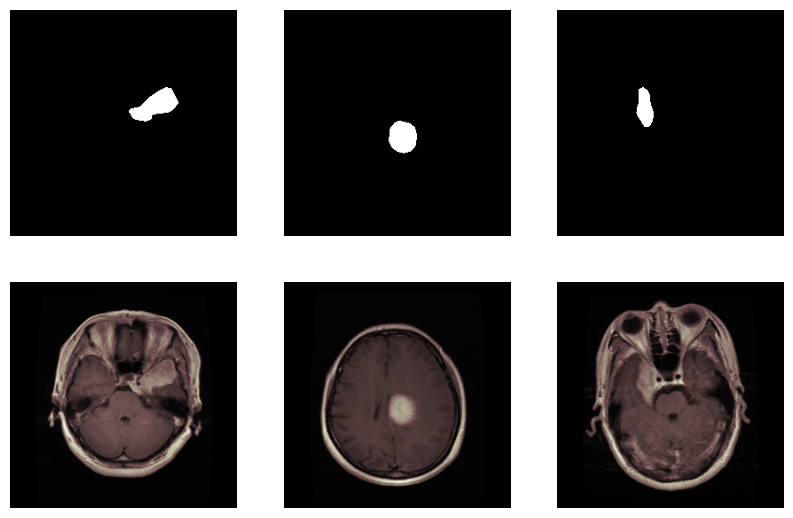

IMAGES:
Unique values: [0.         0.00392157 0.00784314 0.01176471 0.01568627 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313725
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.0745098  0.07843137 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196078 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941176 0.13333333 0.1372549
 0.14117647 0.14509804 0.14901961 0.15294118 0.15686275 0.16078431
 0.16470588 0.16862745 0.17254902 0.17647059 0.18039216 0.18431373
 0.18823529 0.19215686 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568627 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313725 0.24705882 0.25098039 0.25490196
 0.25882353 0.2627451  0.26666667 0.27058824 0.2745098  0.27843137
 0.28235294 0.28627451 0.29019608 0.29411765 0.29803922 0.30196078
 0.30588235 0.30980392 0.31372549 0.31764706 0.32156863 0.3254902
 0.32941176 0.33333333 0.3372549  0.34117

In [ ]:
n_samples = 3
plt.figure(figsize=(10, 10))

# Plot masks
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(masks[i], cmap='gray')

# Plot target images
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray')

plt.show()

print(f'IMAGES:\n'
      f'Unique values: {np.unique(images)}\n'
      f'Shape: {images.shape}\n'
      f'Type: {images.dtype}\n\n'
      f'MASKS:\n'
      f'Unique values: {np.unique(masks)}\n'
      f'Shape: {masks.shape}\n'
      f'Type: {masks.dtype}')

In [ ]:
y = np.expand_dims(masks, axis = 3)
print(y.shape)

(3064, 256, 256, 1)


#### Label Encoding
- Flattened 1D array of masks into integer labels

In [ ]:
labelencoder = LabelEncoder()
n, h, w = masks.shape
train_masks_reshaped = masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
print(train_masks_encoded_original_shape.shape)

[0 1]
(3064, 256, 256)


In [ ]:
# Increase in Dimension.
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis = 3)
print(train_masks_input.shape)

(3064, 256, 256, 1)


#### Train-Test Splits

In [ ]:
# Divide the dataset into training and test sets.

X_train, X_test, y_train, y_test = train_test_split(images, train_masks_input,
                                                    test_size = 0.15, shuffle = True, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.2, random_state = 42)

n_classes = 2
train_masks_cat = to_categorical(y_train, num_classes = n_classes)
test_masks_cat = to_categorical(y_test, num_classes = n_classes)
val_masks_cat = to_categorical(y_val, num_classes = n_classes)

print(f'TRAIN SET:\n'
     f'X_train shape: {X_train.shape}\n'
     f'y_train shape: {train_masks_cat.shape}\n\n'
     f'VALIDATION SET:\n'
     f'X_val shape: {X_val.shape}\n'
     f'y_val shape: {val_masks_cat.shape}\n\n'
     f'TEST SET:\n'
     f'X_test shape: {X_test.shape}\n'
     f'y_test shape: {test_masks_cat.shape}')

TRAIN SET:
X_train shape: (2083, 256, 256, 3)
y_train shape: (2083, 256, 256, 2)

VALIDATION SET:
X_val shape: (521, 256, 256, 3)
y_val shape: (521, 256, 256, 2)

TEST SET:
X_test shape: (460, 256, 256, 3)
y_test shape: (460, 256, 256, 2)


## Modeling | U-Net

In [ ]:
# Model Blocks

# Convolutional Block
def double_conv_block(x, n_filters):
    # Convolution
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

# Downsample Block
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    # Sub-Sampling Layer
    p = MaxPool2D(2)(f)
    return f, p

# Upsample Block
def upsample_block(x, conv_features, n_filters):
    # Transposed Convolution
    x = Conv2DTranspose(n_filters, 3, 2, padding = "same")(x)
    # Concatenation Layer
    x = concatenate([x, conv_features])
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
# U-Net Model

LR = 0.0001 # Learning Rate
optimizer = Adam(LR) # Optimizer
activation = 'sigmoid' # Activation Function of the Output Layer
loss = 'binary_crossentropy' # Loss Function

# Metrics: Dice Coefficient and Mean IoU
def dice_coef(y_true, y_pred, smooth = 1.0):
    class_num = 2 # Classes: Background and Tumor
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

metrics = [dice_coef, tf.keras.metrics.MeanIoU(num_classes = n_classes)]
img_size = (256, 256, 3) # Image Size

def build_unet_model(img_size, num_classes):
    # Input
    inputs = Input(shape = img_size)

    # Encoder
    # 1 - Downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - Downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - Downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - Downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    # 6 - Upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - Upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - Upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - Upsample
    u9 = upsample_block(u8, f1, 64)

    # Output
    outputs = Conv2D(num_classes, 1, padding = "same", activation = activation)(u9)
    unet_model = tf.keras.Model(inputs, outputs, name = "U-Net")
    return unet_model

In [ ]:
# Clearing RAM if a cell with a model was run several times
K.clear_session()

unet_model = build_unet_model(img_size, n_classes)
# output summary information about the model
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

#### Model Plot

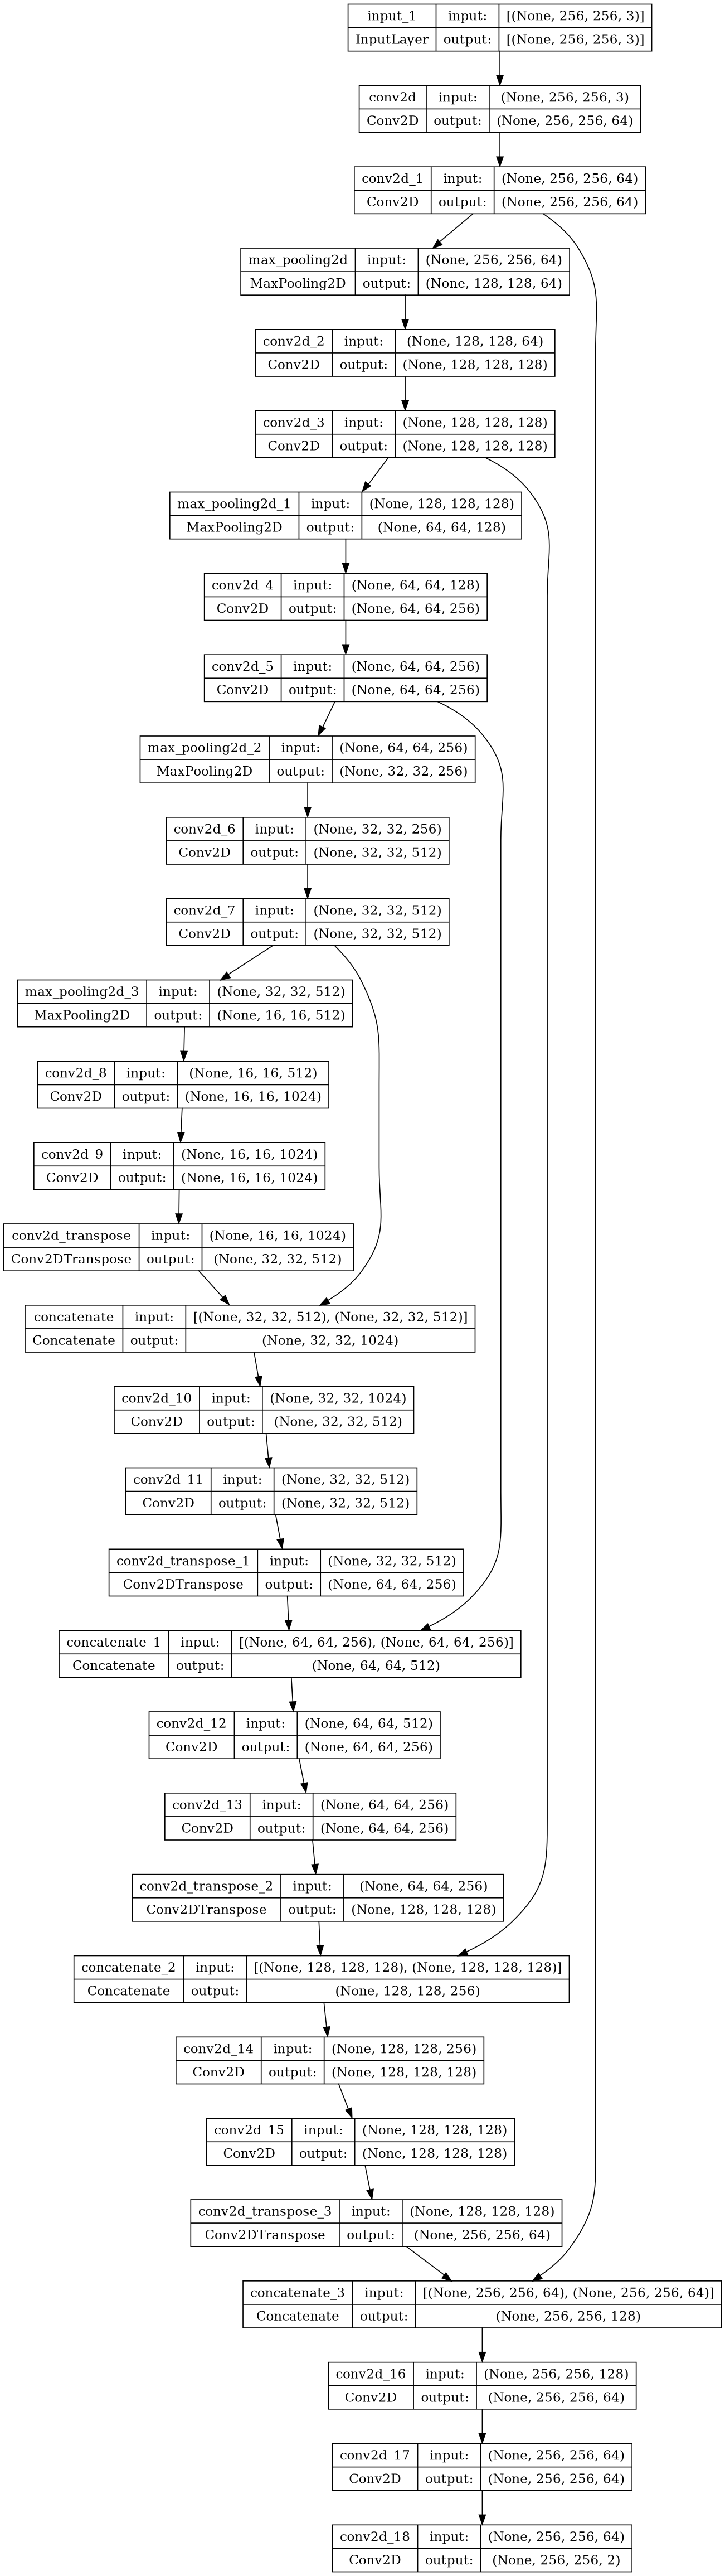

In [ ]:
plot_model(unet_model, show_shapes = True, show_layer_names = True, dpi = 120)

## Training | U-Net

In [ ]:
# model compilation
unet_model.compile(optimizer = optimizer,
                   loss = loss,
                   metrics = metrics)

In [ ]:
# education

earlystopper = EarlyStopping(patience = 5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = '/kaggle/working/checkpoint.hdf5',
                                verbose = 1,
                                save_best_only = True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,
                               patience = 3, min_lr = 0.000001,
                               verbose = 1, cooldown = 1)

history = unet_model.fit(X_train, train_masks_cat, batch_size = 10, epochs = 20, verbose = 1,
                         shuffle = True, callbacks = [earlystopper, checkpointer, reduce_lr],
                         validation_data = (X_val, val_masks_cat))

Epoch 1/20
209/209 [==============================] - ETA: 0s - loss: 0.0924 - dice_coef: 0.5190 - mean_io_u: 0.5356
Epoch 1: val_loss improved from inf to 0.06017, saving model to /kaggle/working/checkpoint.hdf5
209/209 [==============================] - 173s 682ms/step - loss: 0.0924 - dice_coef: 0.5190 - mean_io_u: 0.5356 - val_loss: 0.0602 - val_dice_coef: 0.5380 - val_mean_io_u: 0.5374 - lr: 1.0000e-04
Epoch 2/20
209/209 [==============================] - ETA: 0s - loss: 0.0538 - dice_coef: 0.5740 - mean_io_u: 0.6104
Epoch 2: val_loss improved from 0.06017 to 0.05084, saving model to /kaggle/working/checkpoint.hdf5
209/209 [==============================] - 135s 645ms/step - loss: 0.0538 - dice_coef: 0.5740 - mean_io_u: 0.6104 - val_loss: 0.0508 - val_dice_coef: 0.6018 - val_mean_io_u: 0.5994 - lr: 1.0000e-04
Epoch 3/20
209/209 [==============================] - ETA: 0s - loss: 0.0417 - dice_coef: 0.6565 - mean_io_u: 0.6155
Epoch 3: val_loss improved from 0.05084 to 0.03663, savin

## Learning Curves | U-Net

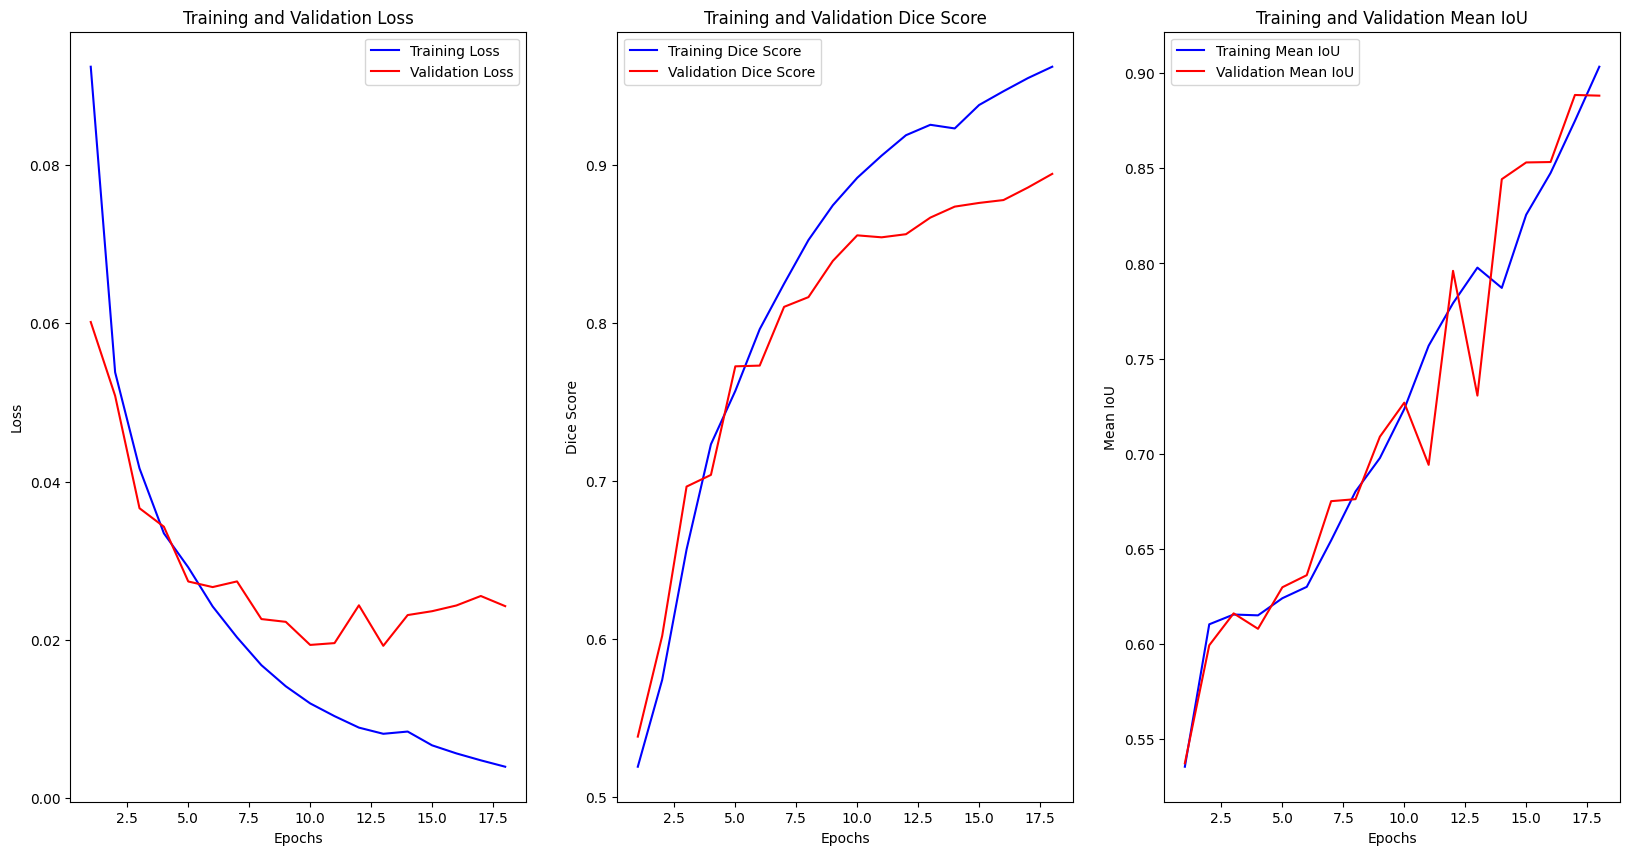

In [ ]:
# Plot Model Accuracy.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

# Plot Model Loss.
plt.subplot(1, 3, 2)
plt.plot(epochs, dice, 'b', label='Training Dice Score')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Score')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()

m_iou = history.history['mean_io_u']
val_m_iou = history.history['val_mean_io_u']

plt.subplot(1, 3, 3)
plt.plot(epochs, m_iou, 'b', label='Training Mean IoU')
plt.plot(epochs, val_m_iou, 'r', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()

plt.show()

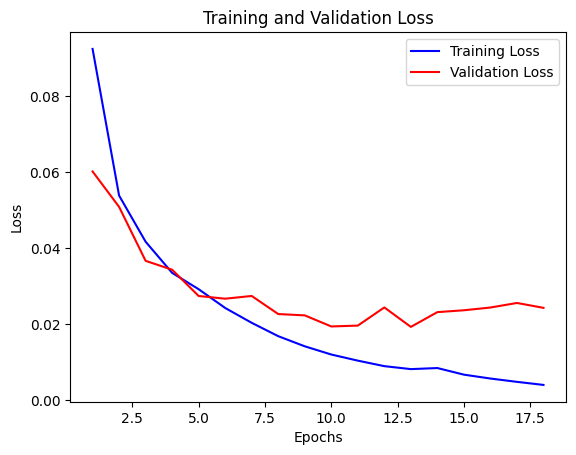

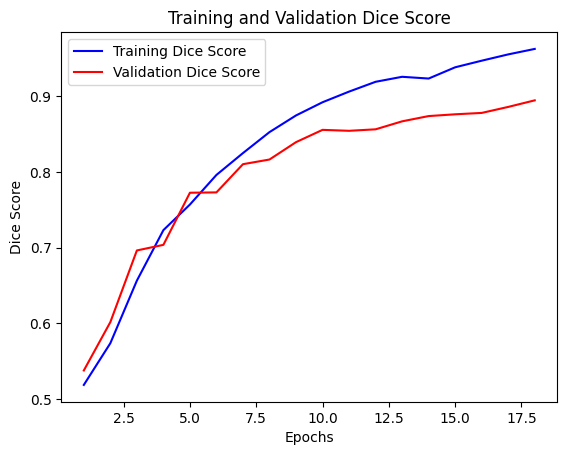

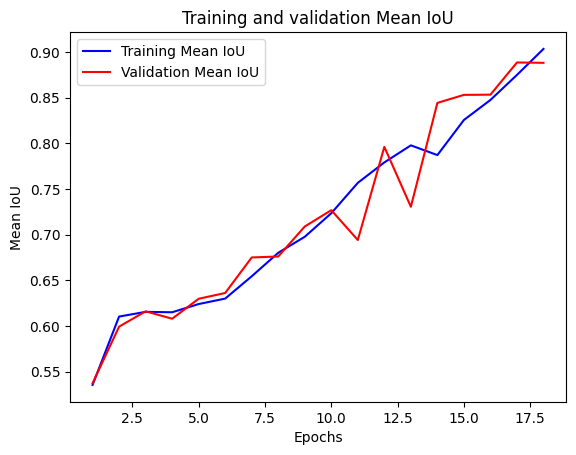

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.plot(epochs, dice, 'b', label='Training Dice Score')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Score')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

m_iou = history.history['mean_io_u']
val_m_iou = history.history['val_mean_io_u']

plt.plot(epochs, m_iou, 'b', label='Training Mean IoU')
plt.plot(epochs, val_m_iou, 'r', label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

## Evaluation | U-Net

In [ ]:
# Evaluation of the Model on Test Images
unet_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
print("Evaluate on test data")
results = unet_model.evaluate(X_test, test_masks_cat, batch_size = 10)

Evaluate on test data
46/46 [==============================] - 11s 217ms/step - loss: 0.0237 - dice_coef: 0.9053 - mean_io_u: 0.8906


## Model Testing | U-Net

1/1 [==============================] - 0s 290ms/step


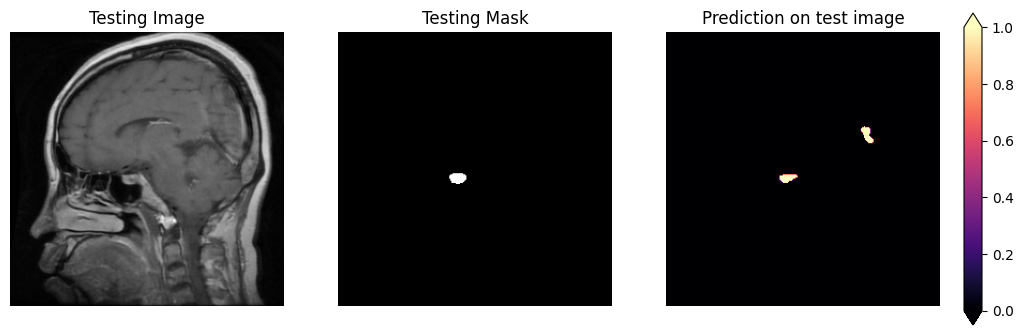

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 27ms/step


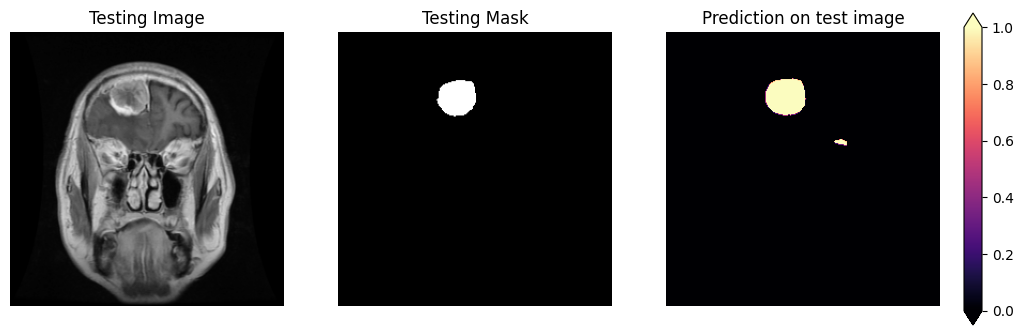

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 22ms/step


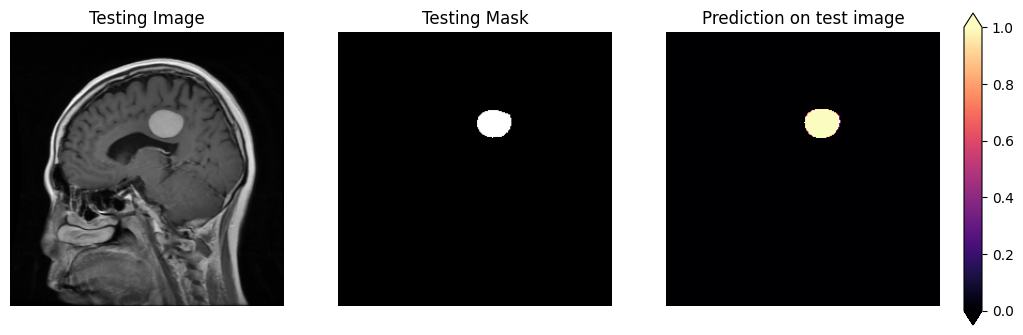

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 22ms/step


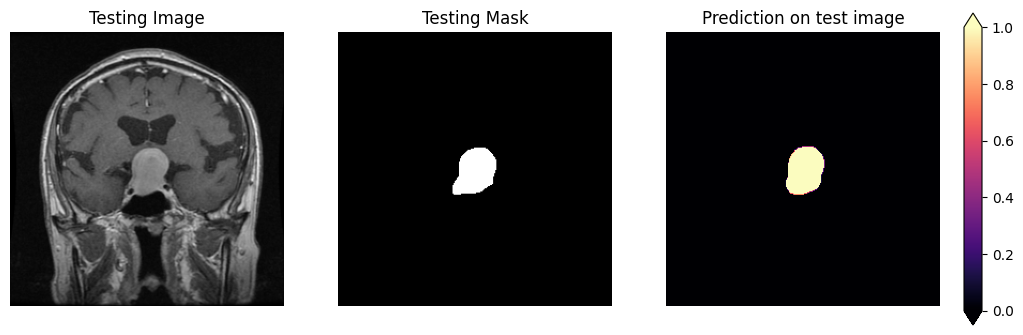

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 22ms/step


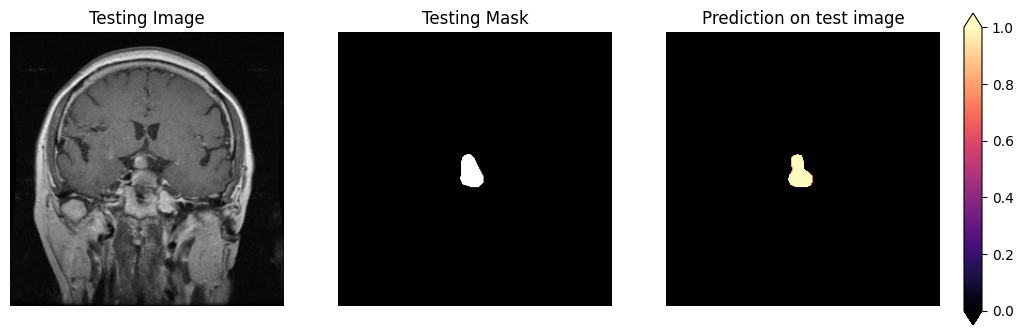

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 24ms/step


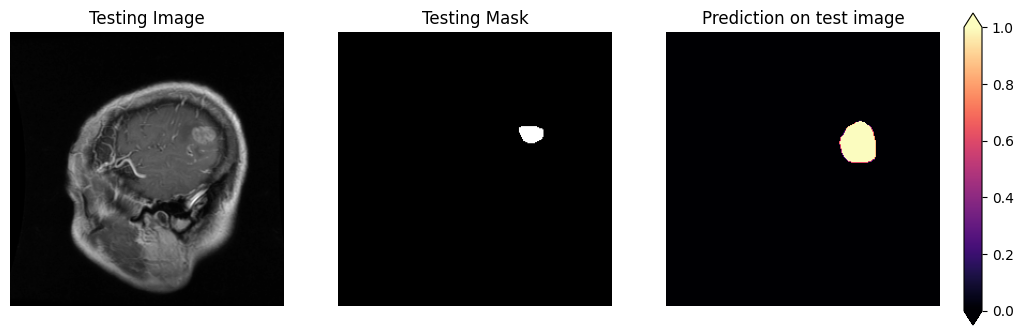

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 21ms/step


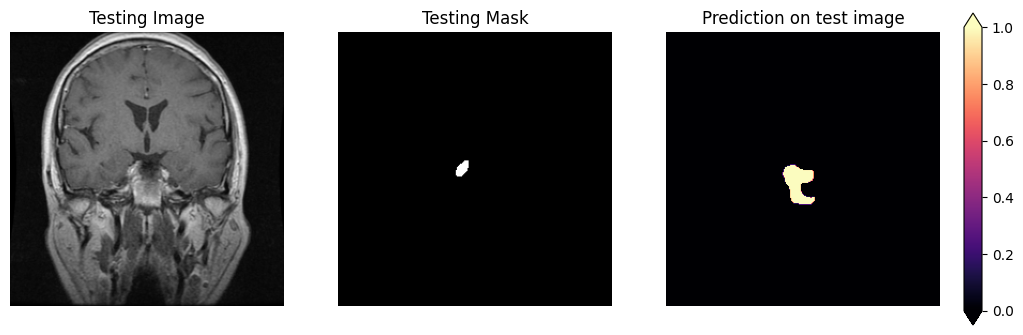

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 21ms/step


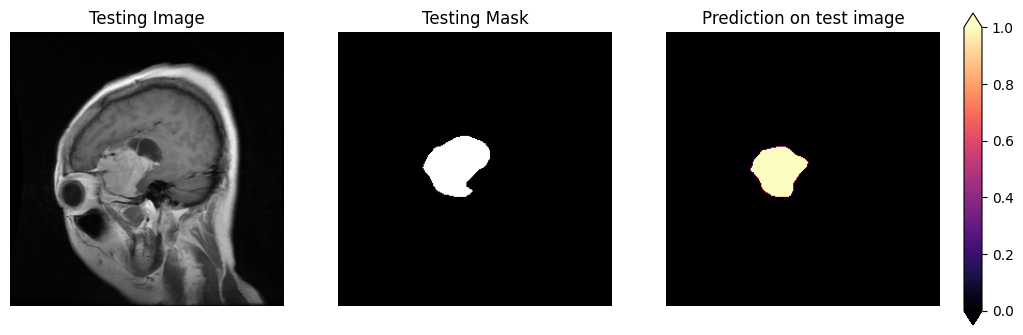

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 21ms/step


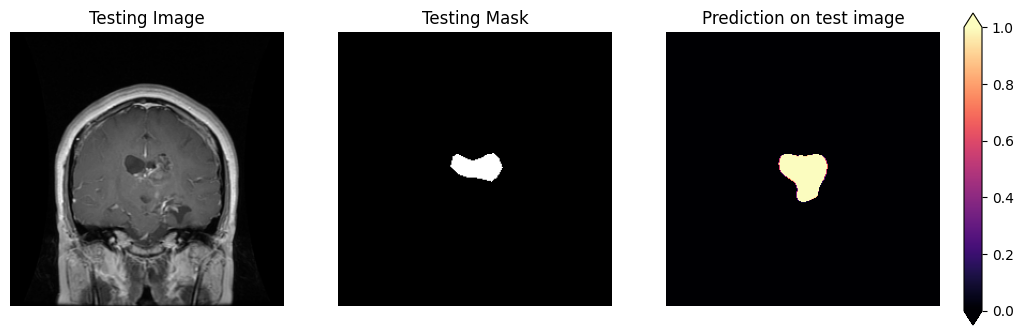

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 23ms/step


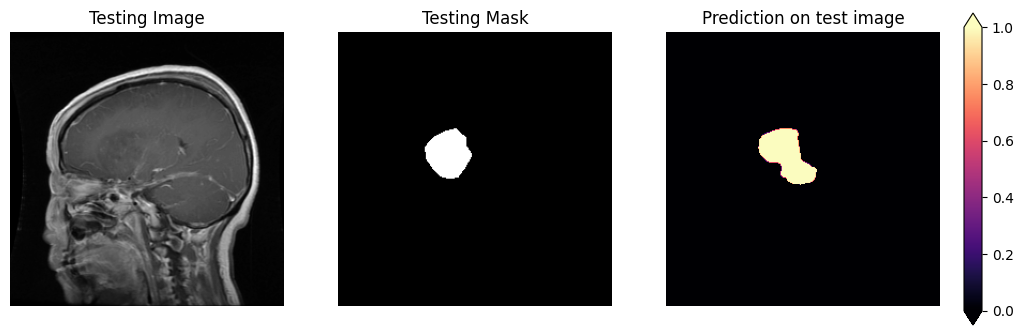

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 22ms/step


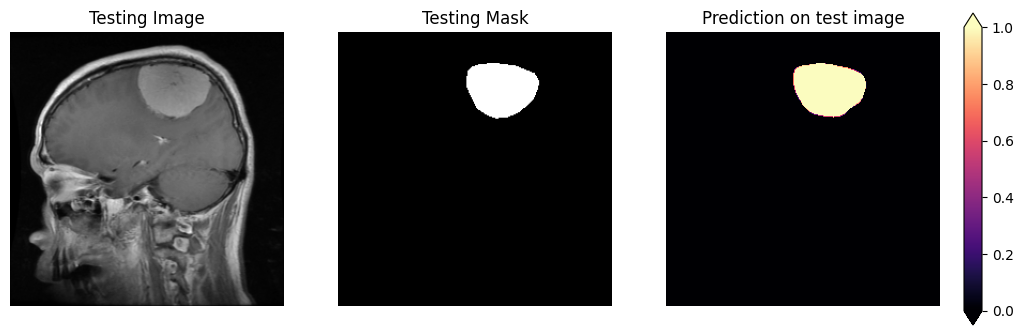

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 24ms/step


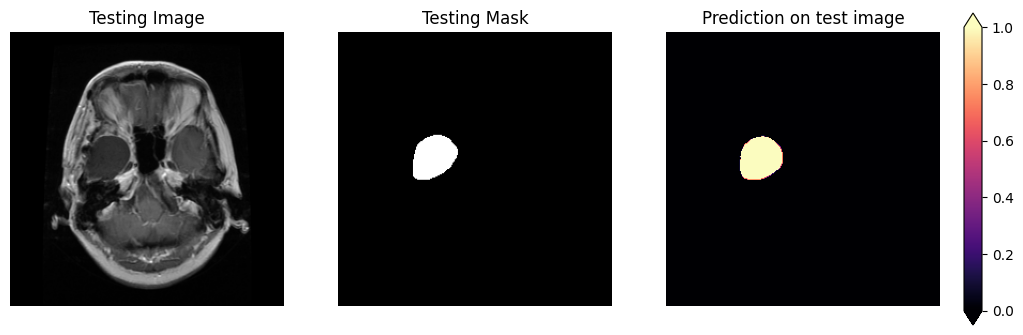

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 23ms/step


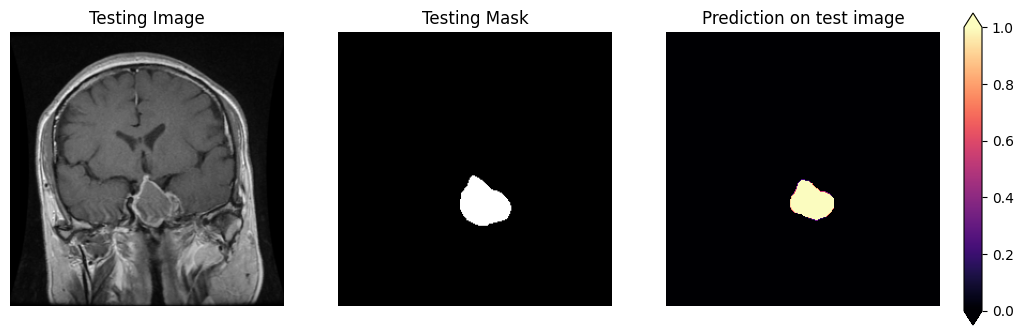

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 22ms/step


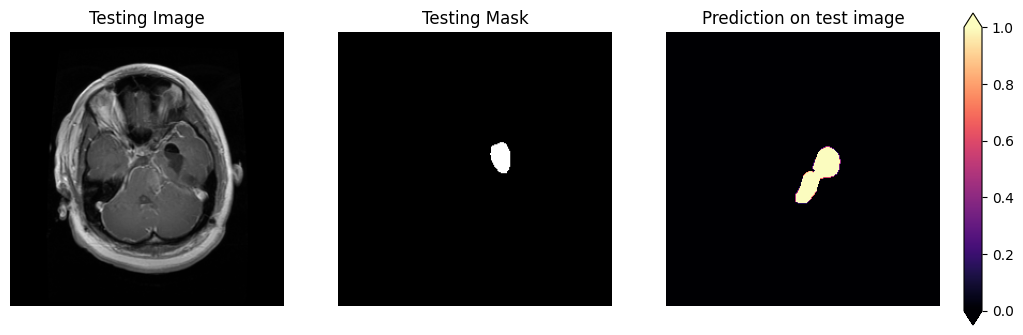

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 21ms/step


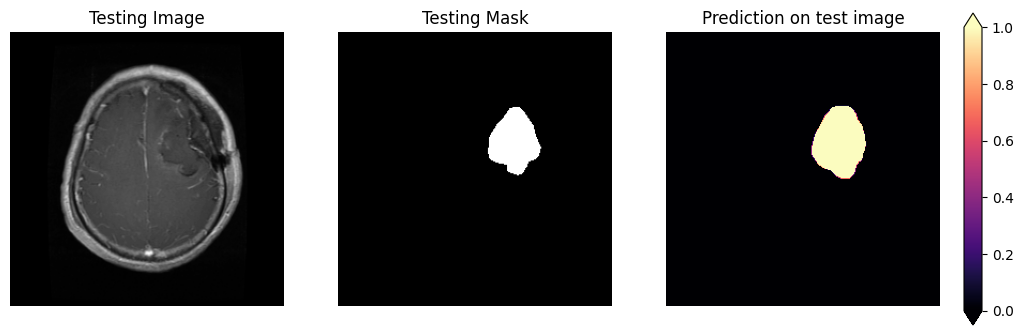

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 23ms/step


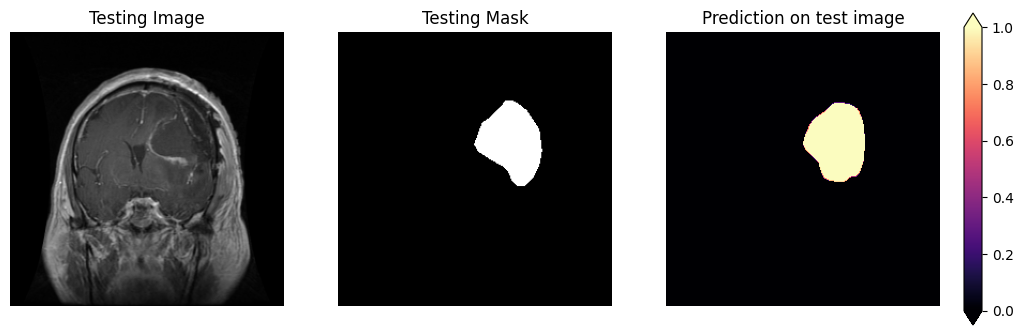

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 22ms/step


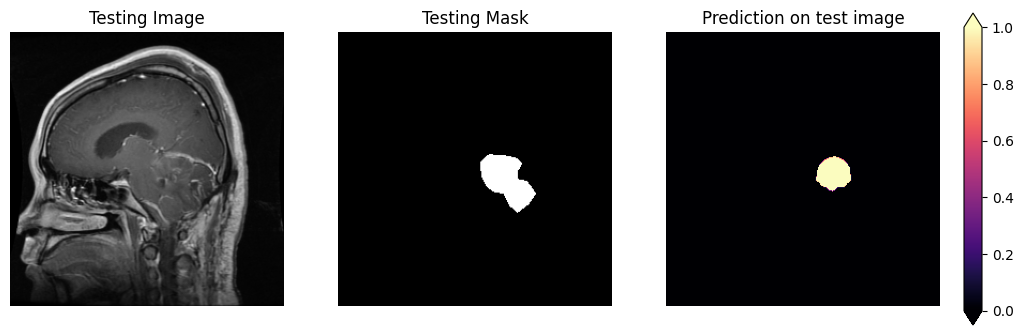

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 23ms/step


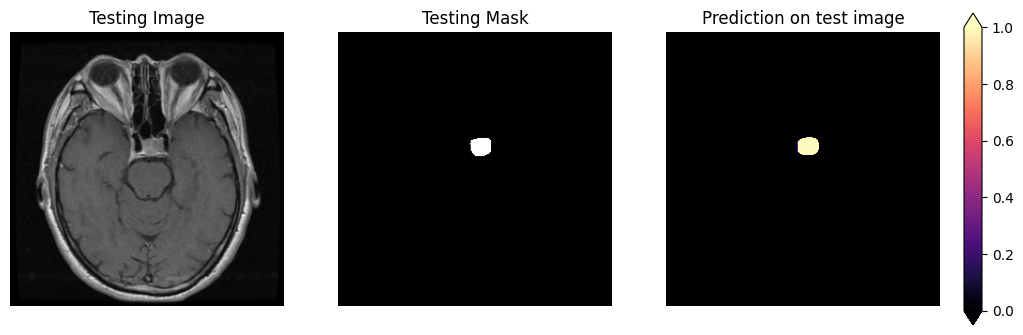

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 23ms/step


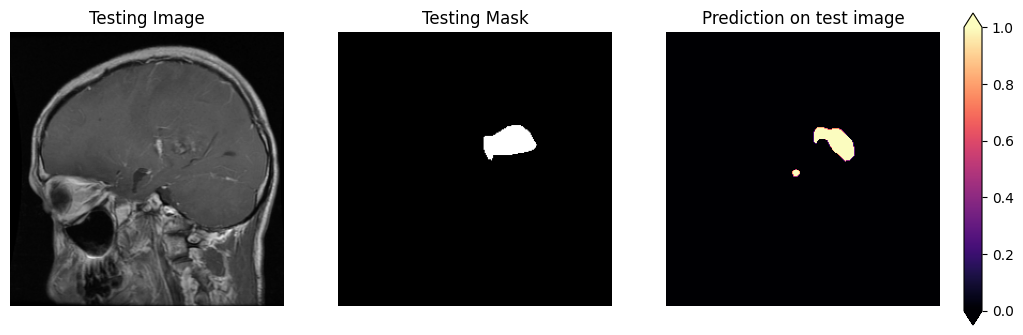

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 24ms/step


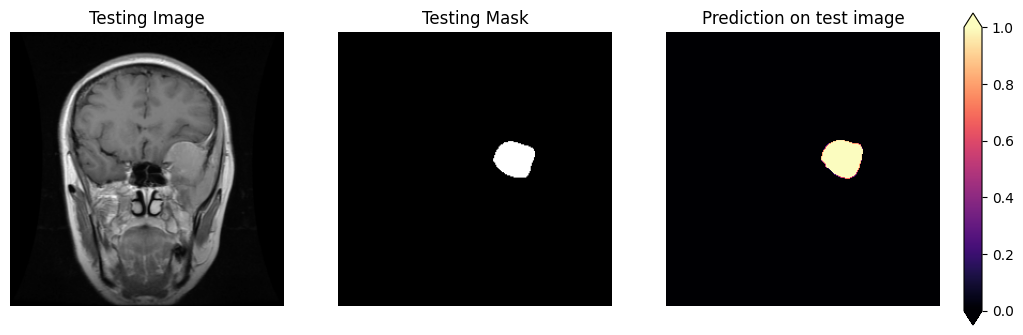

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 21ms/step


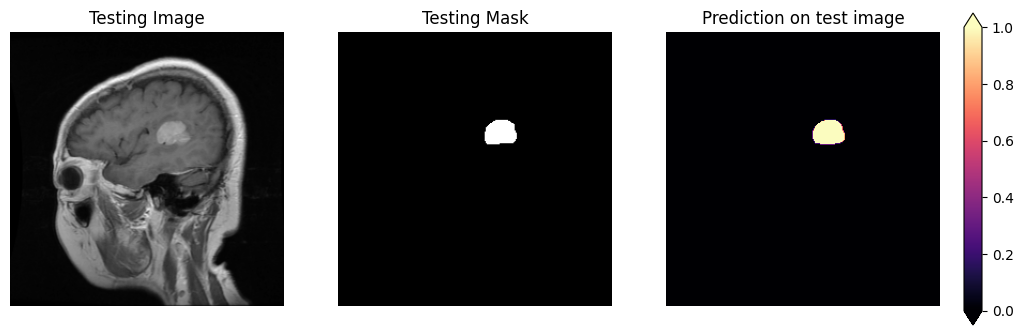

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()

1/1 [==============================] - 0s 22ms/step


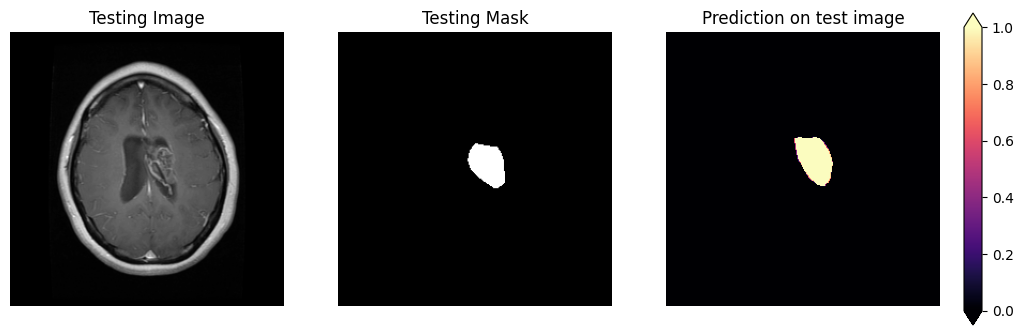

In [ ]:
# Segmentation of Test Shots
test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()